In [1]:
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
import numpy as np
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
from sklearn.cluster import KMeans
import cv2

# Blend cross-over

### SSIM

* Run 1

In [7]:
class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGBA", (self._img_width, self._img_height), (255, 255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image.convert('L'))
    rendered_image = np.array(painting.draw().convert('L'))
    ssim_value = ssim(target_array, rendered_image)
    return 1 - ssim_value

def blend_crossover(parent1, parent2):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    for i in range(len(parent1.triangles)):
        for j in range(3):
            alpha = random.uniform(-0.5, 1.5)
            child1.triangles[i].points[j] = (
                int((1 - alpha) * parent1.triangles[i].points[j][0] + alpha * parent2.triangles[i].points[j][0]),
                int((1 - alpha) * parent1.triangles[i].points[j][1] + alpha * parent2.triangles[i].points[j][1])
            )

    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = blend_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

fitness_file = "fitness_values_.txt"

for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 85  85  85]
 [119  66   0]
 [181 181 181]
 [ 41  36  31]
 [135 135 135]
 [222 222 222]
 [223 123   0]]
Generation 1, Best Fitness: 0.33004245527448417
Generation 2, Best Fitness: 0.3296741731302095
Generation 3, Best Fitness: 0.32904251072851876
Generation 4, Best Fitness: 0.32815795148623905
Generation 5, Best Fitness: 0.32798196527025325
Generation 6, Best Fitness: 0.3273324043918072
Generation 7, Best Fitness: 0.3273324043918072
Generation 8, Best Fitness: 0.3256407009131582
Generation 9, Best Fitness: 0.3256407009131582
Generation 10, Best Fitness: 0.32487806533781327
Generation 11, Best Fitness: 0.3241116695345152
Generation 12, Best Fitness: 0.3241116695345152
Generation 13, Best Fitness: 0.323731490255478
Generation 14, Best Fitness: 0.3227582851360401
Generation 15, Best Fitness: 0.322490859294008
Generation 16, Best Fitness: 0.3216453028671873
Generation 17, Best Fitness: 0.321412410183021
Generation 18, Best F

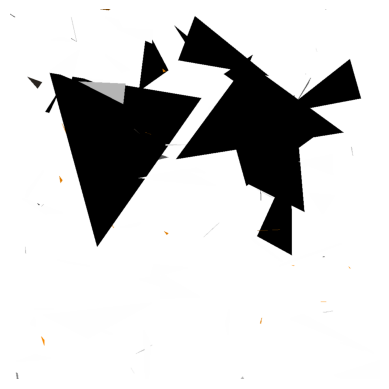

In [8]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off') 
plt.show()

* Run 2

In [9]:
for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 86  86  86]
 [182 182 182]
 [119  66   0]
 [ 41  36  31]
 [222 222 222]
 [223 123   0]
 [136 136 136]]
Generation 1, Best Fitness: 0.32477387564536253
Generation 2, Best Fitness: 0.3246797967686842
Generation 3, Best Fitness: 0.3245133459689534
Generation 4, Best Fitness: 0.32412571085862374
Generation 5, Best Fitness: 0.3237309244535175
Generation 6, Best Fitness: 0.3232192807344242
Generation 7, Best Fitness: 0.32308681933337
Generation 8, Best Fitness: 0.32246462059750103
Generation 9, Best Fitness: 0.32217831802209873
Generation 10, Best Fitness: 0.3216082148103895
Generation 11, Best Fitness: 0.3208437600409241
Generation 12, Best Fitness: 0.3202685446716541
Generation 13, Best Fitness: 0.31958912130345596
Generation 14, Best Fitness: 0.31958912130345596
Generation 15, Best Fitness: 0.31958912130345596
Generation 16, Best Fitness: 0.31951489826931445
Generation 17, Best Fitness: 0.3192589933717007
Generation 18, Be

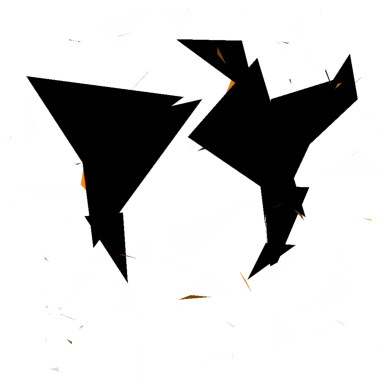

In [10]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 3

In [11]:
for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 71  71  71]
 [159 159 159]
 [119  66   0]
 [210 210 210]
 [223 123   0]
 [113 113 113]
 [ 36  30  24]]
Generation 1, Best Fitness: 0.3293748440982168
Generation 2, Best Fitness: 0.3293017611329585
Generation 3, Best Fitness: 0.3282648418734272
Generation 4, Best Fitness: 0.3282648418734272
Generation 5, Best Fitness: 0.32814186757152186
Generation 6, Best Fitness: 0.3269025149476674
Generation 7, Best Fitness: 0.3262797429151738
Generation 8, Best Fitness: 0.3257673734364006
Generation 9, Best Fitness: 0.3239813350624663
Generation 10, Best Fitness: 0.3239813350624663
Generation 11, Best Fitness: 0.3234899893048051
Generation 12, Best Fitness: 0.3234083435017914
Generation 13, Best Fitness: 0.32239272764260163
Generation 14, Best Fitness: 0.3219594191085585
Generation 15, Best Fitness: 0.32050678853436243
Generation 16, Best Fitness: 0.32050678853436243
Generation 17, Best Fitness: 0.319103869917696
Generation 18, Best 

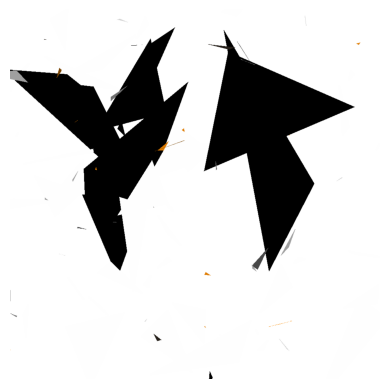

In [12]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 4

In [13]:
for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 85  85  85]
 [182 182 182]
 [119  66   0]
 [135 135 135]
 [ 41  36  30]
 [223 223 223]
 [223 123   0]]
Generation 1, Best Fitness: 0.32617763823496193
Generation 2, Best Fitness: 0.32617763823496193
Generation 3, Best Fitness: 0.32617763823496193
Generation 4, Best Fitness: 0.3261353808597942
Generation 5, Best Fitness: 0.3247962445173328
Generation 6, Best Fitness: 0.32470056365557665
Generation 7, Best Fitness: 0.32438830365492366
Generation 8, Best Fitness: 0.3223079361340563
Generation 9, Best Fitness: 0.3223079361340563
Generation 10, Best Fitness: 0.32168189369948474
Generation 11, Best Fitness: 0.3214445535950917
Generation 12, Best Fitness: 0.3212689423262167
Generation 13, Best Fitness: 0.32107043374819844
Generation 14, Best Fitness: 0.3198644955190202
Generation 15, Best Fitness: 0.31808040873866616
Generation 16, Best Fitness: 0.31789080897052235
Generation 17, Best Fitness: 0.31721810415188145
Generation 18

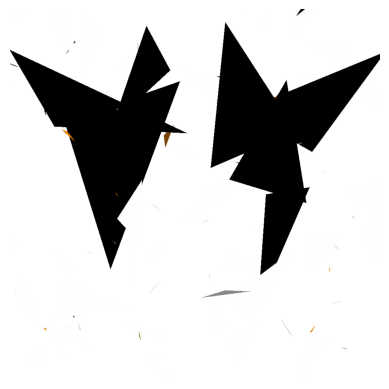

In [14]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off') 
plt.show()

* Run 5

In [15]:
for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [109 109 109]
 [123  68   0]
 [187 187 187]
 [ 37  31  24]
 [ 71  71  71]
 [224 224 224]
 [147 147 147]]
Generation 1, Best Fitness: 0.3292093576739029
Generation 2, Best Fitness: 0.3292093576739029
Generation 3, Best Fitness: 0.3291463810110139
Generation 4, Best Fitness: 0.32828028246313334
Generation 5, Best Fitness: 0.3275163589753217
Generation 6, Best Fitness: 0.32744114084687226
Generation 7, Best Fitness: 0.3270814004803667
Generation 8, Best Fitness: 0.32650828595611303
Generation 9, Best Fitness: 0.3249426756776821
Generation 10, Best Fitness: 0.3244591686996461
Generation 11, Best Fitness: 0.3240167656720525
Generation 12, Best Fitness: 0.3226927167070376
Generation 13, Best Fitness: 0.3218043060694328
Generation 14, Best Fitness: 0.3205727708940903
Generation 15, Best Fitness: 0.3203721057015826
Generation 16, Best Fitness: 0.31995933429066215
Generation 17, Best Fitness: 0.318766306508217
Generation 18, Best 

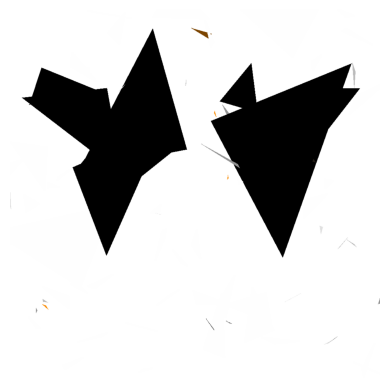

In [16]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

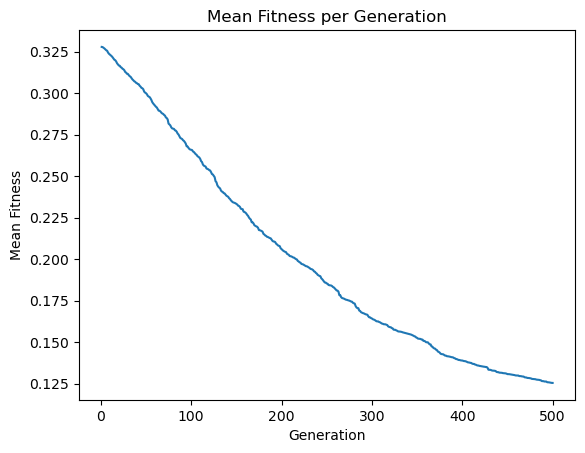

In [17]:
fitness_file = "fitness_values_blend.txt"

with open(fitness_file, "r") as file:
    fitness_values = [float(line.strip()) for line in file]

num_generations_per_run = 500
num_runs = len(fitness_values) // num_generations_per_run

fitness_values = np.array(fitness_values)
fitness_values = fitness_values.reshape(num_runs, num_generations_per_run)

mean_fitness_per_generation = np.mean(fitness_values, axis=0)

plt.plot(range(1, num_generations_per_run + 1), mean_fitness_per_generation)
plt.xlabel('Generation')
plt.ylabel('Mean Fitness')
plt.title('Mean Fitness per Generation')
plt.show()

## Euclidean distance

* Run 1

In [1]:
class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGB", (self._img_width, self._img_height), (255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image)
    rendered_image = np.array(painting.draw())
    # Calculate the Euclidean distance
    distance = np.sqrt(np.sum((target_array - rendered_image) ** 2))
    return distance

def blend_crossover(parent1, parent2):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    for i in range(len(parent1.triangles)):
        for j in range(3):
            alpha = random.uniform(-0.5, 1.5)
            child1.triangles[i].points[j] = (
                int((1 - alpha) * parent1.triangles[i].points[j][0] + alpha * parent2.triangles[i].points[j][0]),
                int((1 - alpha) * parent1.triangles[i].points[j][1] + alpha * parent2.triangles[i].points[j][1])
            )
            child2.triangles[i].points[j] = (
                int(alpha * parent1.triangles[i].points[j][0] + (1 - alpha) * parent2.triangles[i].points[j][0]),
                int(alpha * parent1.triangles[i].points[j][1] + (1 - alpha) * parent2.triangles[i].points[j][1])
            )

    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = blend_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

fitness_file = "fitness_values_euclidean_blend.txt"

for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")


Run 1
Extracted palette: [[  0   0   0]
 [254 254 254]
 [250 138   0]
 [ 86  86  86]
 [119  66   0]
 [182 182 182]
 [ 41  36  31]
 [136 136 136]
 [222 222 222]
 [223 123   0]]
Generation 1, Best Fitness: 4874.8984604809975
Generation 2, Best Fitness: 4874.8984604809975
Generation 3, Best Fitness: 4874.8984604809975
Generation 4, Best Fitness: 4874.8984604809975
Generation 5, Best Fitness: 4874.8984604809975
Generation 6, Best Fitness: 4874.8984604809975
Generation 7, Best Fitness: 4853.683549635267
Generation 8, Best Fitness: 4853.683549635267
Generation 9, Best Fitness: 4841.223812219386
Generation 10, Best Fitness: 4798.779844918914
Generation 11, Best Fitness: 4798.779844918914
Generation 12, Best Fitness: 4725.977888225885
Generation 13, Best Fitness: 4689.962259976086
Generation 14, Best Fitness: 4621.8848968791945
Generation 15, Best Fitness: 4621.8848968791945
Generation 16, Best Fitness: 4592.373242670939
Generation 17, Best Fitness: 4592.373242670939
Generation 18, Best Fitnes

Generation 169, Best Fitness: 2805.122100729307
Generation 170, Best Fitness: 2805.122100729307
Generation 171, Best Fitness: 2805.122100729307
Generation 172, Best Fitness: 2799.7692762083093
Generation 173, Best Fitness: 2793.037414715385
Generation 174, Best Fitness: 2788.601262281863
Generation 175, Best Fitness: 2788.601262281863
Generation 176, Best Fitness: 2788.601262281863
Generation 177, Best Fitness: 2788.601262281863
Generation 178, Best Fitness: 2780.2685122124444
Generation 179, Best Fitness: 2775.293678153719
Generation 180, Best Fitness: 2775.293678153719
Generation 181, Best Fitness: 2775.293678153719
Generation 182, Best Fitness: 2775.293678153719
Generation 183, Best Fitness: 2766.5117024874485
Generation 184, Best Fitness: 2766.5117024874485
Generation 185, Best Fitness: 2766.5117024874485
Generation 186, Best Fitness: 2765.487298831799
Generation 187, Best Fitness: 2765.487298831799
Generation 188, Best Fitness: 2760.871058198843
Generation 189, Best Fitness: 2760.

Generation 339, Best Fitness: 2525.376605577869
Generation 340, Best Fitness: 2523.9904912657653
Generation 341, Best Fitness: 2522.0362804686215
Generation 342, Best Fitness: 2522.0362804686215
Generation 343, Best Fitness: 2522.0362804686215
Generation 344, Best Fitness: 2522.0362804686215
Generation 345, Best Fitness: 2522.0362804686215
Generation 346, Best Fitness: 2522.0362804686215
Generation 347, Best Fitness: 2522.0362804686215
Generation 348, Best Fitness: 2522.0362804686215
Generation 349, Best Fitness: 2522.0362804686215
Generation 350, Best Fitness: 2520.859773966017
Generation 351, Best Fitness: 2520.593977617181
Generation 352, Best Fitness: 2520.593977617181
Generation 353, Best Fitness: 2519.369762460445
Generation 354, Best Fitness: 2518.7445285300373
Generation 355, Best Fitness: 2518.7445285300373
Generation 356, Best Fitness: 2516.918949827348
Generation 357, Best Fitness: 2516.918949827348
Generation 358, Best Fitness: 2516.918949827348
Generation 359, Best Fitness

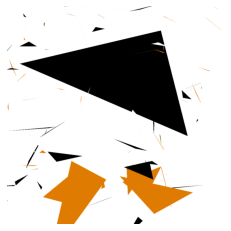

In [3]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 2

In [4]:
for run in range(1):
    print(f"Run {run + 2}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 2
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [133 133 133]
 [119  66   0]
 [ 82  82  82]
 [181 181 181]
 [223 223 223]
 [ 39  34  28]
 [223 123   0]]
Generation 1, Best Fitness: 4578.609505079025
Generation 2, Best Fitness: 4578.609505079025
Generation 3, Best Fitness: 4578.609505079025
Generation 4, Best Fitness: 4578.467647586908
Generation 5, Best Fitness: 4562.599368780914
Generation 6, Best Fitness: 4507.539572760288
Generation 7, Best Fitness: 4442.136648055753
Generation 8, Best Fitness: 4442.136648055753
Generation 9, Best Fitness: 4419.420437116161
Generation 10, Best Fitness: 4356.18502820989
Generation 11, Best Fitness: 4355.5262598221125
Generation 12, Best Fitness: 4292.158547863767
Generation 13, Best Fitness: 4276.235026281881
Generation 14, Best Fitness: 4191.280234009651
Generation 15, Best Fitness: 4191.280234009651
Generation 16, Best Fitness: 4138.430378778891
Generation 17, Best Fitness: 4138.430378778891
Generation 18, Best Fitness: 4134.

Generation 169, Best Fitness: 2893.2213880033446
Generation 170, Best Fitness: 2893.2213880033446
Generation 171, Best Fitness: 2890.7971219025385
Generation 172, Best Fitness: 2887.3882662364617
Generation 173, Best Fitness: 2887.3882662364617
Generation 174, Best Fitness: 2877.1371187345244
Generation 175, Best Fitness: 2865.5095532906535
Generation 176, Best Fitness: 2863.275222537994
Generation 177, Best Fitness: 2858.978139125936
Generation 178, Best Fitness: 2855.932072021322
Generation 179, Best Fitness: 2855.932072021322
Generation 180, Best Fitness: 2850.6883379282276
Generation 181, Best Fitness: 2850.6883379282276
Generation 182, Best Fitness: 2848.2524466767336
Generation 183, Best Fitness: 2837.962120959334
Generation 184, Best Fitness: 2834.1014449027757
Generation 185, Best Fitness: 2834.1014449027757
Generation 186, Best Fitness: 2833.7231692598343
Generation 187, Best Fitness: 2823.8799549555924
Generation 188, Best Fitness: 2802.8865478288626
Generation 189, Best Fitn

Generation 338, Best Fitness: 2061.9997575169596
Generation 339, Best Fitness: 2059.4637651583
Generation 340, Best Fitness: 2059.4637651583
Generation 341, Best Fitness: 2059.4637651583
Generation 342, Best Fitness: 2059.148367651054
Generation 343, Best Fitness: 2055.3963121500437
Generation 344, Best Fitness: 2055.3963121500437
Generation 345, Best Fitness: 2046.415646930017
Generation 346, Best Fitness: 2046.415646930017
Generation 347, Best Fitness: 2039.666394290988
Generation 348, Best Fitness: 2039.666394290988
Generation 349, Best Fitness: 2039.666394290988
Generation 350, Best Fitness: 2039.666394290988
Generation 351, Best Fitness: 2024.989876517905
Generation 352, Best Fitness: 2021.3124449228526
Generation 353, Best Fitness: 2018.9024245861908
Generation 354, Best Fitness: 2018.269803569384
Generation 355, Best Fitness: 2018.269803569384
Generation 356, Best Fitness: 2018.269803569384
Generation 357, Best Fitness: 2008.9805872631025
Generation 358, Best Fitness: 2003.97904

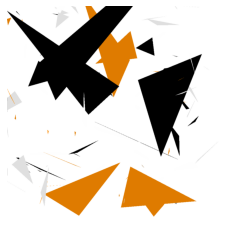

In [5]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 3

In [6]:
for run in range(1):
    print(f"Run {run + 3}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 3
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [107 107 107]
 [186 186 186]
 [123  68   0]
 [ 36  30  23]
 [146 146 146]
 [225 225 225]
 [ 69  69  69]]
Generation 1, Best Fitness: 4878.109572365098
Generation 2, Best Fitness: 4878.109572365098
Generation 3, Best Fitness: 4878.109572365098
Generation 4, Best Fitness: 4878.109572365098
Generation 5, Best Fitness: 4878.109572365098
Generation 6, Best Fitness: 4878.109572365098
Generation 7, Best Fitness: 4803.865839092511
Generation 8, Best Fitness: 4803.865839092511
Generation 9, Best Fitness: 4803.865839092511
Generation 10, Best Fitness: 4764.1927962667505
Generation 11, Best Fitness: 4764.1927962667505
Generation 12, Best Fitness: 4715.010922574836
Generation 13, Best Fitness: 4686.129319598425
Generation 14, Best Fitness: 4665.821792567735
Generation 15, Best Fitness: 4636.585920696391
Generation 16, Best Fitness: 4636.585920696391
Generation 17, Best Fitness: 4587.318933756405
Generation 18, Best Fitness: 458

Generation 170, Best Fitness: 3091.3314283654545
Generation 171, Best Fitness: 3091.3314283654545
Generation 172, Best Fitness: 3091.3314283654545
Generation 173, Best Fitness: 3089.041922667933
Generation 174, Best Fitness: 3089.041922667933
Generation 175, Best Fitness: 3071.011234105144
Generation 176, Best Fitness: 3071.011234105144
Generation 177, Best Fitness: 3064.6247731166045
Generation 178, Best Fitness: 3064.6247731166045
Generation 179, Best Fitness: 3064.5967108250966
Generation 180, Best Fitness: 3055.5902866713004
Generation 181, Best Fitness: 3055.5902866713004
Generation 182, Best Fitness: 3052.3851329738845
Generation 183, Best Fitness: 3052.3851329738845
Generation 184, Best Fitness: 3052.3851329738845
Generation 185, Best Fitness: 3048.89160187764
Generation 186, Best Fitness: 3048.89160187764
Generation 187, Best Fitness: 3033.9695120419387
Generation 188, Best Fitness: 3033.9695120419387
Generation 189, Best Fitness: 3033.9695120419387
Generation 190, Best Fitness

Generation 339, Best Fitness: 2700.106664559754
Generation 340, Best Fitness: 2697.3959664832305
Generation 341, Best Fitness: 2658.065085734358
Generation 342, Best Fitness: 2658.065085734358
Generation 343, Best Fitness: 2658.065085734358
Generation 344, Best Fitness: 2652.435673112545
Generation 345, Best Fitness: 2640.162494999124
Generation 346, Best Fitness: 2633.366476584678
Generation 347, Best Fitness: 2633.0488031937425
Generation 348, Best Fitness: 2629.1009870295966
Generation 349, Best Fitness: 2625.859478342282
Generation 350, Best Fitness: 2620.1082038725044
Generation 351, Best Fitness: 2609.7501796148995
Generation 352, Best Fitness: 2609.7501796148995
Generation 353, Best Fitness: 2609.7501796148995
Generation 354, Best Fitness: 2609.7501796148995
Generation 355, Best Fitness: 2607.7616838967474
Generation 356, Best Fitness: 2579.897284777051
Generation 357, Best Fitness: 2565.2925759063037
Generation 358, Best Fitness: 2511.569031502021
Generation 359, Best Fitness: 

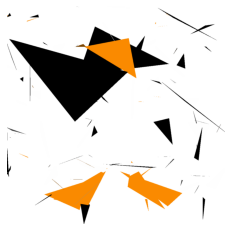

In [7]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 4 

In [2]:
population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

fitness_file = "fitness_values_euclidean_blend.txt"

for run in range(1):
    print(f"Run {run + 4}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 4
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [118 118 118]
 [119  66   0]
 [212 212 212]
 [ 37  31  24]
 [164 164 164]
 [ 74  74  74]
 [223 123   0]]
Generation 1, Best Fitness: 4630.140710604808
Generation 2, Best Fitness: 4614.174574070643
Generation 3, Best Fitness: 4614.174574070643
Generation 4, Best Fitness: 4614.174574070643
Generation 5, Best Fitness: 4614.174574070643
Generation 6, Best Fitness: 4589.848908188591
Generation 7, Best Fitness: 4589.848908188591
Generation 8, Best Fitness: 4528.238951292213
Generation 9, Best Fitness: 4528.238951292213
Generation 10, Best Fitness: 4528.238951292213
Generation 11, Best Fitness: 4526.247231426935
Generation 12, Best Fitness: 4449.331635200954
Generation 13, Best Fitness: 4428.303738453359
Generation 14, Best Fitness: 4409.8804972470625
Generation 15, Best Fitness: 4370.408676542733
Generation 16, Best Fitness: 4311.639131467289
Generation 17, Best Fitness: 4311.639131467289
Generation 18, Best Fitness: 4281

Generation 169, Best Fitness: 2527.439415693282
Generation 170, Best Fitness: 2526.413267856231
Generation 171, Best Fitness: 2510.8229726525924
Generation 172, Best Fitness: 2502.6471984680543
Generation 173, Best Fitness: 2502.6471984680543
Generation 174, Best Fitness: 2498.1142888186682
Generation 175, Best Fitness: 2495.860973692245
Generation 176, Best Fitness: 2495.604736331457
Generation 177, Best Fitness: 2493.230033510747
Generation 178, Best Fitness: 2485.0329977688425
Generation 179, Best Fitness: 2484.548852407616
Generation 180, Best Fitness: 2481.0495762882288
Generation 181, Best Fitness: 2471.8064244596503
Generation 182, Best Fitness: 2471.8064244596503
Generation 183, Best Fitness: 2471.8064244596503
Generation 184, Best Fitness: 2460.608461336342
Generation 185, Best Fitness: 2457.2413393885427
Generation 186, Best Fitness: 2457.2413393885427
Generation 187, Best Fitness: 2456.8730125914117
Generation 188, Best Fitness: 2456.734010836338
Generation 189, Best Fitness

Generation 338, Best Fitness: 2136.4290299469344
Generation 339, Best Fitness: 2136.4290299469344
Generation 340, Best Fitness: 2135.603661731268
Generation 341, Best Fitness: 2135.603661731268
Generation 342, Best Fitness: 2135.603661731268
Generation 343, Best Fitness: 2135.603661731268
Generation 344, Best Fitness: 2135.603661731268
Generation 345, Best Fitness: 2132.3707463759674
Generation 346, Best Fitness: 2132.3707463759674
Generation 347, Best Fitness: 2132.3707463759674
Generation 348, Best Fitness: 2132.0297840321086
Generation 349, Best Fitness: 2132.0297840321086
Generation 350, Best Fitness: 2132.0297840321086
Generation 351, Best Fitness: 2130.931251823953
Generation 352, Best Fitness: 2130.9249165561887
Generation 353, Best Fitness: 2130.9249165561887
Generation 354, Best Fitness: 2123.3030871733786
Generation 355, Best Fitness: 2123.3030871733786
Generation 356, Best Fitness: 2120.9361140779324
Generation 357, Best Fitness: 2120.9361140779324
Generation 358, Best Fitne

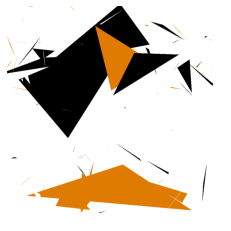

In [3]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 5 

In [4]:
for run in range(1):
    print(f"Run {run + 5}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 5
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [125 125 125]
 [ 39  35  29]
 [212 212 212]
 [119  66   0]
 [167 167 167]
 [ 81  81  81]
 [223 123   0]]
Generation 1, Best Fitness: 4417.618249690663
Generation 2, Best Fitness: 4417.618249690663
Generation 3, Best Fitness: 4417.618249690663
Generation 4, Best Fitness: 4416.5821627136065
Generation 5, Best Fitness: 4416.5821627136065
Generation 6, Best Fitness: 4415.060701734462
Generation 7, Best Fitness: 4382.935431876678
Generation 8, Best Fitness: 4382.935431876678
Generation 9, Best Fitness: 4370.239123892422
Generation 10, Best Fitness: 4358.294276434302
Generation 11, Best Fitness: 4304.319342242162
Generation 12, Best Fitness: 4284.916218550837
Generation 13, Best Fitness: 4275.125144367122
Generation 14, Best Fitness: 4208.448288858971
Generation 15, Best Fitness: 4129.804232648323
Generation 16, Best Fitness: 4115.902452682765
Generation 17, Best Fitness: 4087.8359800755215
Generation 18, Best Fitness: 40

Generation 169, Best Fitness: 2676.834324346578
Generation 170, Best Fitness: 2676.834324346578
Generation 171, Best Fitness: 2676.834324346578
Generation 172, Best Fitness: 2676.834324346578
Generation 173, Best Fitness: 2672.7074288069766
Generation 174, Best Fitness: 2672.7074288069766
Generation 175, Best Fitness: 2672.7074288069766
Generation 176, Best Fitness: 2669.1138979069437
Generation 177, Best Fitness: 2669.1138979069437
Generation 178, Best Fitness: 2667.4141035842185
Generation 179, Best Fitness: 2667.4141035842185
Generation 180, Best Fitness: 2667.4141035842185
Generation 181, Best Fitness: 2667.4141035842185
Generation 182, Best Fitness: 2664.268567543445
Generation 183, Best Fitness: 2662.481549231844
Generation 184, Best Fitness: 2662.481549231844
Generation 185, Best Fitness: 2662.4330977510026
Generation 186, Best Fitness: 2641.587969385082
Generation 187, Best Fitness: 2630.2754608595656
Generation 188, Best Fitness: 2608.107168043522
Generation 189, Best Fitness:

Generation 338, Best Fitness: 2511.957006001496
Generation 339, Best Fitness: 2506.116517642386
Generation 340, Best Fitness: 2505.9555063887306
Generation 341, Best Fitness: 2503.3996884237245
Generation 342, Best Fitness: 2503.3996884237245
Generation 343, Best Fitness: 2503.3996884237245
Generation 344, Best Fitness: 2503.3996884237245
Generation 345, Best Fitness: 2499.3947267288536
Generation 346, Best Fitness: 2499.3947267288536
Generation 347, Best Fitness: 2498.125697397951
Generation 348, Best Fitness: 2498.125697397951
Generation 349, Best Fitness: 2498.125697397951
Generation 350, Best Fitness: 2498.125697397951
Generation 351, Best Fitness: 2498.125697397951
Generation 352, Best Fitness: 2498.125697397951
Generation 353, Best Fitness: 2498.125697397951
Generation 354, Best Fitness: 2495.0681353421996
Generation 355, Best Fitness: 2491.8067742102317
Generation 356, Best Fitness: 2491.8067742102317
Generation 357, Best Fitness: 2490.750890795786
Generation 358, Best Fitness: 

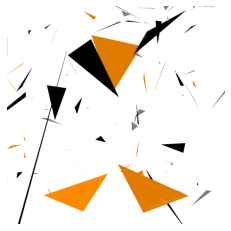

In [5]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

## Plotting mean fitness per generation 

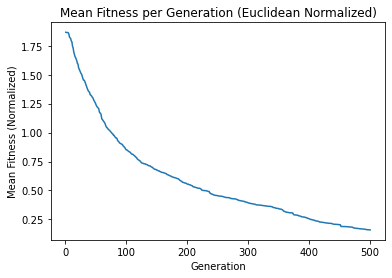

In [6]:
fitness_file = "fitness_values_euclidean_blend.txt"

with open(fitness_file, "r") as file:
    fitness_values = [float(line.strip()) for line in file]

num_generations_per_run = 500
num_runs = len(fitness_values) // num_generations_per_run

fitness_values = np.array(fitness_values)
fitness_values = fitness_values.reshape(num_runs, num_generations_per_run)

min_value = np.min(fitness_values)
max_value = np.max(fitness_values)
normalized_fitness_values = 2 * (fitness_values - min_value) / (max_value - min_value)

mean_fitness_per_generation = np.mean(normalized_fitness_values, axis=0)

plt.plot(range(1, num_generations_per_run + 1), mean_fitness_per_generation)
plt.xlabel('Generation')
plt.ylabel('Mean Fitness (Normalized)')
plt.title('Mean Fitness per Generation (Euclidean Normalized)')
plt.show()